In [1]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import sys
sys.path.append('/root/capsule/code/beh_ephys_analysis')
from utils.beh_functions import parseSessionID, session_dirs, plot_session_in_time_all, plot_session_glm, transfer_nwb, get_unit_tbl
from utils.ephys_functions import make_summary_unit_tbl
from utils.hdf5_extractor import HDF5Recording
from utils.opto_utils import opto_metrics, load_opto_sig
from unit_beh_analysis import plot_unit_beh_session, plot_alignments, burst_analysis
from behavior_and_time_alignment import beh_and_time_alignment_hopkins
import shutil
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
import pandas as  pd
from joblib import Parallel, delayed
from aind_dynamic_foraging_basic_analysis.plot.plot_foraging_session import plot_foraging_session, plot_foraging_session_nwb
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import plot_lick_analysis
import datetime
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
from utils.hdf5_extractor import read_hdf5 
import spikeinterface.widgets as sw

In [2]:
import h5py
print(h5py.__version__)

3.14.0


In [3]:
session = 'behavior_ZS061_2021-03-28_16-35-51'
session_dir = session_dirs(session)

Old data, using hopkins formats


In [4]:
rec = read_hdf5(session_dir['raw_rec'])


(32, 95402336)


In [5]:
# traces = rec.get_traces(start_frame=int(1438*rec.sampling_frequency), end_frame=int(1453*rec.sampling_frequency))

In [6]:
rec.get_property('offset_to_uV').shape

(32,)

In [7]:
sample = rec.get_traces(start_frame=0, end_frame=10, return_scaled=True)
sample.shape

(10, 32)

In [8]:
rec.get_channel_ids()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31'], dtype='<U2')

In [9]:
bad_channels= ['10']
rec = rec.remove_channels(bad_channels)

In [10]:
recording_raw_fake = spre.bandpass_filter(rec, freq_min=50, freq_max=8000)
recording_raw_fake = spre.common_reference(recording_raw_fake)

In [11]:
recording_raw_fake

CommonReferenceRecording: 31 channels - 32.0kHz - 1 segments - 95,402,336 samples 
                          2,981.32s (49.69 minutes) - int16 dtype - 5.51 GiB

In [12]:
sorting = se.read_nwb_sorting(
    session_dir['nwb_dir_curated'], sampling_frequency=rec.sampling_frequency, t_start=rec.get_start_time(), load_unit_properties=True
)

/opt/conda/lib/python3.10/site-packages/spikeinterface/extractors/nwbextractors.py:1334: UserWarning: Skipping wf_2d_opto because of unequal shapes across units
  warnings.warn(f"Skipping {property_name} because of unequal shapes across units")


In [13]:
sorting = sorting.rename_units(sorting.get_property('unit_id'))

In [14]:
units = list(sorting.unit_ids)
group = [int(unit_id[2])-1 for unit_id in units]
sorting.set_property('group', group)

In [15]:
sorting.get_property('group')

array([0, 0, 2, 2, 2, 3, 4])

In [1]:
sparsity_params_file = '/root/capsule/code/beh_ephys_analysis/params.json'
with open(sparsity_params_file, 'r') as f:
    postprocessing_params = json.load(f)
job_kwargs = postprocessing_params.pop("job_kwargs")
job_kwargs["n_jobs"] = 8
# si.set_global_job_kwargs(**job_kwargs)

sparsity_params = postprocessing_params.pop("sparsity")
quality_metrics_names = postprocessing_params.pop("quality_metrics_names")
quality_metrics_params = postprocessing_params.pop("quality_metrics")

analyzer_dict = postprocessing_params.copy()
analyzer_dict.pop("duplicate_threshold")
analyzer_dict.pop("return_scaled")

NameError: name 'json' is not defined

In [19]:
si.set_global_job_kwargs(n_jobs=-1, progress_bar=True)

In [18]:
analyzer = si.create_sorting_analyzer(
    sorting=sorting,
    recording=recording_raw_fake,
    method="by_property",
    by_property="group")

In [20]:
_ = analyzer.compute("random_spikes", method="uniform")
_ = analyzer.compute(["waveforms", "templates"])
_ = analyzer.compute(
    "quality_metrics",
    metric_names=quality_metrics_names,
    qm_params=quality_metrics_params
)
waveform_zarr_folder = f'{session_dir[f"ephys_dir_{data_type}"]}/waveforms.zarr'
if os.path.exists(waveform_zarr_folder):
    print("Zarr folder already exists, deleting.")
    shutil.rmtree(waveform_zarr_folder)

compute_waveforms (workers: 16 processes):   0%|          | 0/2982 [00:00<?, ?it/s]

AssertionError: Extension quality_metrics requires noise_levels to be computed first

In [13]:
%matplotlib widget

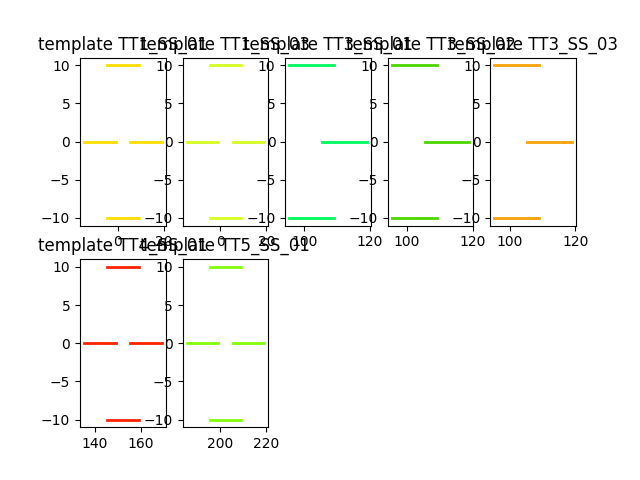

In [25]:
sw.plot_unit_templates(analyzer)

In [15]:
sw.plot_traces(spre.highpass_filter(rec), backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [21]:
sorting.set_sorting_info(recording_dict, params_dict, log_dict)

[]